In [1]:
!CUDA_VISIBLE_DEVICE=1

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy import stats
import torch
import sys
sys.path.append('..')
from VAE.VAE_model import VAE

In [3]:
def load_VAE():
    autoencoder = VAE(
        num_genes=14652,
        device='cuda',
        seed=0,
        
        hparams="",
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load('/data1/lep/Workspace/guided-diffusion/VAE/checkpoint/muris_mam_spl_T_B/model_seed=0_step=499999.pt'))#rea
    return autoencoder

real data

In [14]:
# real data in h5ad format
adata = sc.read_h5ad('/data1/lep/Workspace/guided-diffusion/data/tabula_muris/mam_spl_T_B.h5ad')
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=10)
adata.var_names_make_unique()

gene_names = adata.var_names
cellclass = adata.obs['celltype']
organtype = adata.obs['organ']
celltype = [cellclass[i]+'_'+organtype[i] for i in range(len(cellclass))]
adata.obs['cellinfo'] = celltype

sc.pp.normalize_total(adata, target_sum=1e4)

cell_data = adata.X.toarray()

cell_data.shape

(11330, 14652)

In [15]:
# less cells to increase mapping time
adata_list = []
for cellt in np.unique(adata.obs['cellinfo']):
    if cellt == 'B cell_spleen':
        adata_list.append(adata[adata.obs['cellinfo']==cellt][:1200])
    else:
        adata_list.append(adata[adata.obs['cellinfo']==cellt][:700])
adata = ad.concat(adata_list)

gene_names = adata.var_names
cellclass = adata.obs['celltype']
organtype = adata.obs['organ']
celltype = [cellclass[i]+'_'+organtype[i] for i in range(len(cellclass))]
adata.obs['cellinfo'] = celltype

sc.pp.normalize_total(adata, target_sum=1e4)

cell_data = adata.X.toarray()

cell_data.shape

(3300, 14652)

generated data

In [16]:
cell_gen_all = []
gen_class = []

# different conditional generations in the same folder
file_list = os.listdir('/data1/lep/Workspace/guided-diffusion/data/new_version/muris')
cato = ['mam_B', 'mam_T', 'spl_T', 'spl_B']

autoencoder = load_VAE()
for i in range(len(cato)):
    npzfile=np.load('../data/new_version/muris_old/'+cato[i]+'.npz',allow_pickle=True)
    cell_gen_tmp = autoencoder(torch.tensor(npzfile['cell_gen']).cuda(),return_decoded=True).cpu().detach().numpy()

    #cell filter
    dis = np.linalg.norm((cell_gen_tmp-cell_gen_tmp.mean(axis=0)),axis=1)
    # find all the index where dis is smaller than 100
    idx = np.where(dis<np.median(dis))[0]
    cell_gen_tmp = cell_gen_tmp[idx]
    print(cell_gen_tmp.shape[0])

    if cato[i] == 'spl_B':
        cell_gen_all.append(cell_gen_tmp[:600])#.squeeze(1)
        gen_class+=['gen '+cato[i]]*600
    else:
        cell_gen_all.append(cell_gen_tmp[:300])#.squeeze(1)
        gen_class+=['gen '+cato[i]]*300
cell_gen_all = np.concatenate(cell_gen_all,axis=0)

ori = ad.AnnData(cell_gen_all, dtype=np.float32)#[::2]
ori.obs['celltype'] = gen_class
cell_gen = ori.X
gen_class = ori.obs['celltype']

cell_gen.shape

3000
3000
3000
3000


(1500, 14652)

draw plot

In [7]:
real_adata = ad.AnnData(cell_data, dtype=np.float32)
gen_adata = ad.AnnData(cell_gen, dtype=np.float32)
real_adata.var_names = gene_names
gen_adata.var_names = gene_names

sc.pp.log1p(real_adata)
sc.pp.highly_variable_genes(real_adata)
gen_adata = gen_adata[:,real_adata.var['highly_variable']]
real_adata = real_adata[:, real_adata.var.highly_variable]
sc.pp.scale(real_adata)

sc.pp.log1p(gen_adata)
sc.pp.scale(gen_adata)
sc.tl.pca(real_adata, svd_solver='arpack')

X_pca = np.dot(gen_adata.X, real_adata.varm['PCs'])
gen_adata.obsm['X_pca'] = X_pca

adata = sc.concat((real_adata,gen_adata))

adata.obs['celltype'] = np.concatenate((celltype, gen_class))
adata.obs['cell_name'] = [f"Generated Cell" for i in range(cell_data.shape[0])]+[f"Real Cell" for i in range(cell_gen.shape[0])]
adata

/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/data1/lep/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 4800 × 1101
    obs: 'celltype', 'cell_name'
    obsm: 'X_pca'

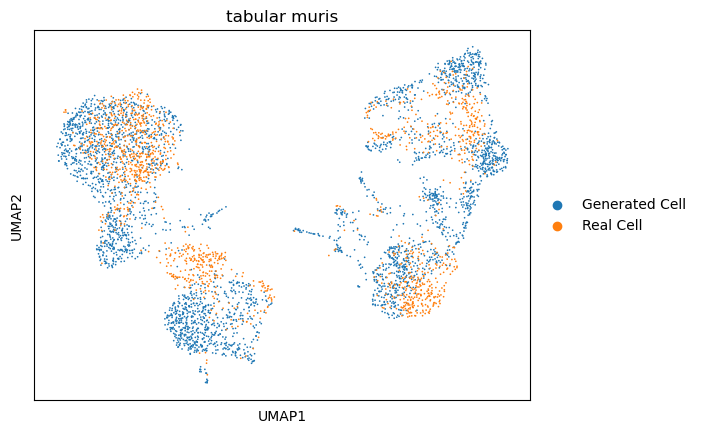

In [8]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.pl.umap(adata=adata,color="cell_name",size=6,title='tabular muris')

<AxesSubplot:title={'center':'tabular muris'}, xlabel='UMAP1', ylabel='UMAP2'>

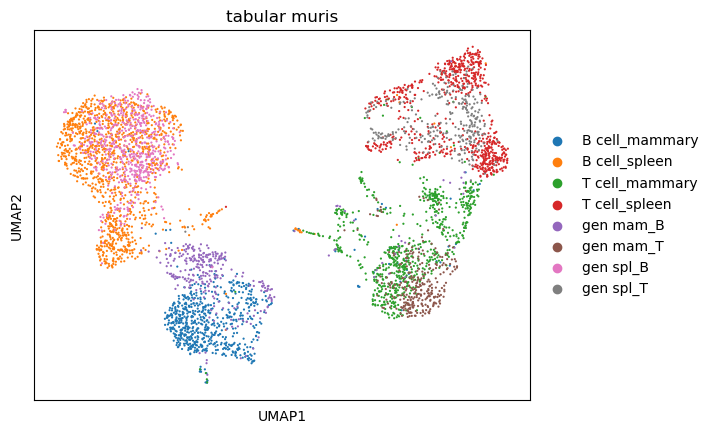

In [9]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sc.pl.umap(adata=adata,color="celltype",size=10,title='tabular muris', show = False)

celltypist test

In [10]:
import celltypist
# replace with the cell you generated
npzfile=np.load('../data/new_version/muris_old/mam_B_test.npz',allow_pickle=True)
cell_gen_all = npzfile['cell_gen'][:9000]
autoencoder = load_VAE()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()

ori = ad.AnnData(cell_gen_all, dtype=np.float32)
ori.var_names = gene_names
print(ori)

#cell filter
dis = np.linalg.norm((ori.X-ori.X.mean(axis=0)),axis=1)
# find all the index where dis is smaller than 100
idx = np.where(dis<np.median(dis))[0]
ori = ori[idx]
print(ori)

sc.pp.normalize_total(ori, target_sum=1e4)
sc.pp.log1p(ori)

# replace with the celltypist you trained
predictions = celltypist.annotate(ori, model = '/data1/lep/Workspace/guided-diffusion/checkpoint/celltypist_muris_mam_re.pkl')
print((predictions.predicted_labels.squeeze(1).values == 'B cell').sum()/ori[:127].X.shape[0])

AnnData object with n_obs × n_vars = 6000 × 14652
View of AnnData object with n_obs × n_vars = 3000 × 14652


🔬 Input data has 3000 cells and 14652 genes
🔗 Matching reference genes in the model
🧬 14228 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


20.070866141732285


MMD

In [11]:
import torch

def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):

    n_samples = int(source.size()[0])+int(target.size()[0])
    total = torch.cat([source, target], dim=0)

    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))

    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))

    L2_distance = ((total0-total1)**2).sum(2) 

    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)

    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]

    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]

    return sum(kernel_val)

def mmd_rbf(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    batch_size = int(source.size()[0])
    kernels = guassian_kernel(source, target,
        kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)

    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    loss = torch.mean(XX + YY - XY -YX)
    return loss

In [17]:
npzfile=np.load('../data/new_version/muris_old/mam_B_test.npz',allow_pickle=True)
cell_gen_all = npzfile['cell_gen'][:9000]
autoencoder = load_VAE()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()

ori = ad.AnnData(cell_gen_all, dtype=np.float32)
ori.var_names = gene_names

#cell filter
dis = np.linalg.norm((ori.X-ori.X.mean(axis=0)),axis=1)
# find all the index where dis is smaller than 100
idx = np.where(dis<np.median(dis))[0]
ori = ori[idx]
print(ori)

cell_gen = ori.X
cell_gen.shape

View of AnnData object with n_obs × n_vars = 3000 × 14652


(3000, 14652)

In [18]:
cell_data = adata[adata.obs['cellinfo']=='B cell_mammary',].X.toarray()
adata_mmd = np.concatenate((cell_data, cell_gen),axis=0)
adata_mmd = ad.AnnData(adata_mmd, dtype=np.float32)
adata_mmd.obs_names = [f"true_Cell" for i in range(cell_data.shape[0])]+[f"gen_Cell" for i in range(cell_gen.shape[0])]

In [20]:
from torch.autograd import Variable
sc.tl.pca(adata_mmd, svd_solver='arpack')# svd_solver 指定奇异值分解 SVD 的方法
real = adata_mmd[adata_mmd.obs_names=='true_Cell'].obsm['X_pca'][:700]#[:cell_data.shape[0]]
gen = adata_mmd[adata_mmd.obs_names=='gen_Cell'].obsm['X_pca'][:700]#[:cell_data.shape[0]]#.X.toarray()
X = torch.Tensor(real)
Y = torch.Tensor(gen)
X,Y = Variable(X), Variable(Y)
print(mmd_rbf(X,Y))

tensor(0.9861)
